<a href="https://colab.research.google.com/github/tirthpatel1111/Tops/blob/main/Nueral%20network%20and%20deep%20learning/Assignment/CNN_Mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!mkdir -p ~/.kaggle # creating .kaggle folder to store kaggle file
!cp kaggle.json ~/.kaggle/

In [13]:
!kaggle datasets download -d hojjatk/mnist-dataset

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
  0% 0.00/22.0M [00:00<?, ?B/s]
100% 22.0M/22.0M [00:00<00:00, 1.25GB/s]


In [14]:
!unzip /content/mnist-dataset.zip

Archive:  /content/mnist-dataset.zip
  inflating: t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: t10k-images.idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: t10k-labels.idx1-ubyte  
  inflating: train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: train-images.idx3-ubyte  
  inflating: train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: train-labels.idx1-ubyte  


In [15]:
import os
import numpy as np
import struct
import pickle
from array import array
%matplotlib inline
import random
import matplotlib.pyplot as plt
from typing import Tuple
from os.path  import join
import csv
import glob
import imageio
from glob import glob
import shutil
import json

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision.utils as vutils
from torchvision.io import read_image
from torchvision.transforms.functional import rgb_to_grayscale


In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [17]:
torch.manual_seed(42)

In [18]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath, test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    # parsing the raw MNIST binary files into Python lists / NumPy arrays.
    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def read_split(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)

        x_train = np.asarray(x_train)
        x_test  = np.asarray(x_test)
        y_train = np.asarray(y_train, dtype=np.int64)
        y_test  = np.asarray(y_test,  dtype=np.int64)
        return x_train, y_train, x_test, y_test

    def preprocess_images(self, x):
        # Convert to float and Rescale -1 to 1
        x = x.astype(np.float32, copy=False)
        x = (x / 127.5) - 1.0

        #Add channels dimension. As the input to our generator and discriminator. has a shape 1x28x28.
        x = np.expand_dims(x, axis=1)
        return np.ascontiguousarray(x)

    def load_data(self):
        x_train, y_train, x_test, y_test = self.read_split()
        x_train = self.preprocess_images(x_train)
        x_test  = self.preprocess_images(x_test)

        # Create tensor view of the NumPy array
        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train)
        x_test= torch.from_numpy(x_test)
        y_test = torch.from_numpy(y_test)

        return (x_train, y_train),(x_test, y_test)

In [20]:
input_path = '/content'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [21]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

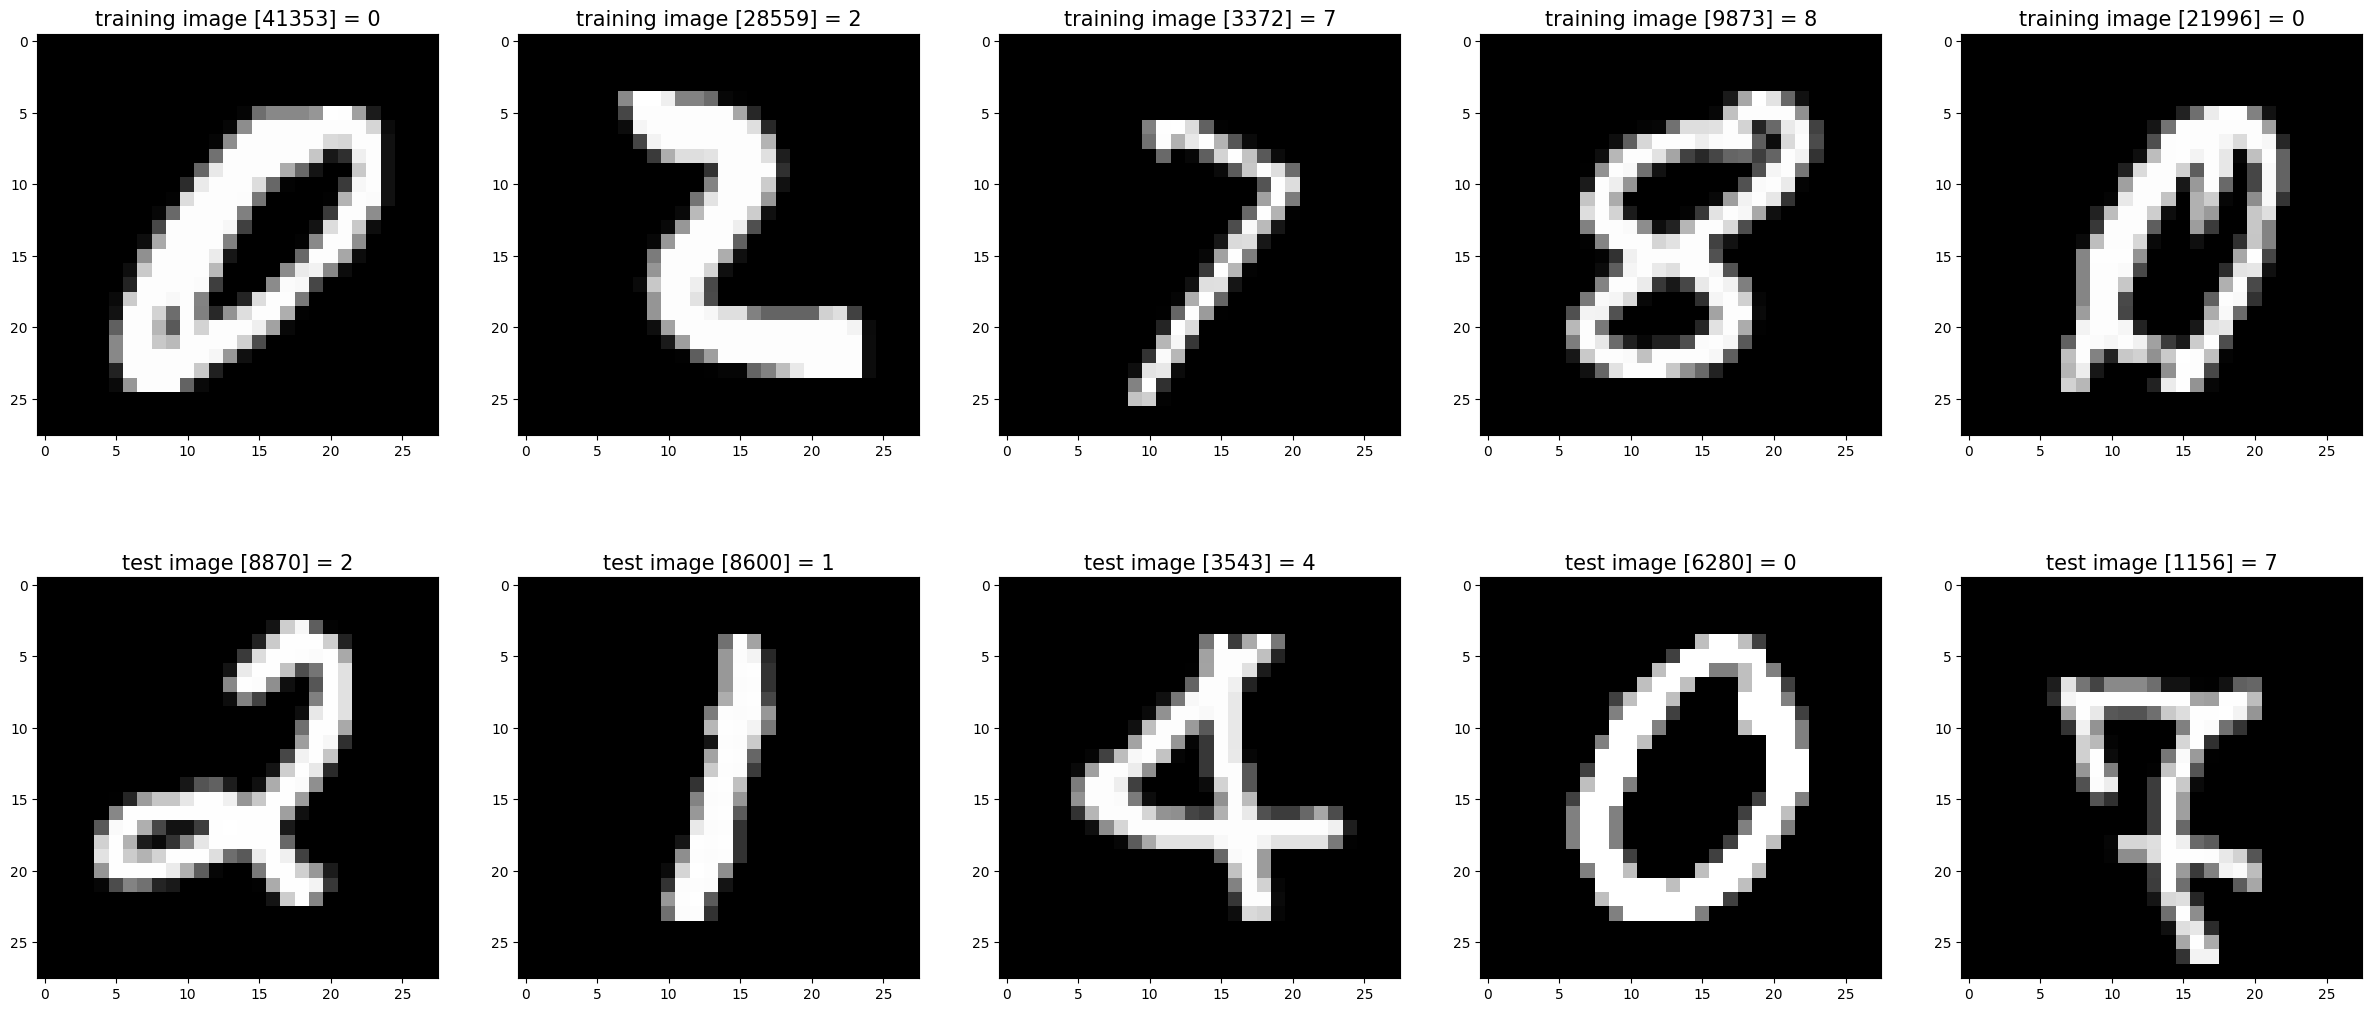

In [22]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
x_train_, y_train_, x_test_, y_test_ = mnist_dataloader.read_split()

images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train_[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train_[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test_[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test_[r]))

show_images(images_2_show, titles_2_show)

In [23]:
x_train_tensor = torch.from_numpy(x_train_).float()   # images -> float32
y_train_tensor = torch.from_numpy(y_train_).long()    # labels -> int64 (for classification)

x_test_tensor = torch.from_numpy(x_test_).float()
y_test_tensor = torch.from_numpy(y_test_).long()

In [24]:
x_train_tensor=x_train_tensor.unsqueeze(1)
x_test_tensor=x_test_tensor.unsqueeze(1)

In [25]:
full_train=TensorDataset(x_train_tensor,y_train_tensor)
full_test=TensorDataset(x_test_tensor,y_test_tensor)

In [26]:
print(full_train.tensors[0].shape)
print(full_train.tensors[1].shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])


In [27]:
train_loader = DataLoader(full_train, batch_size=64, shuffle=True,num_workers=2,pin_memory=True)
test_loader = DataLoader(full_test, batch_size=64, shuffle=True,num_workers=2.,pin_memory=True)

In [28]:
f,l=next(iter(train_loader))

In [33]:
class MNISTNet(nn.Module):
    def __init__(self,in_feathers):
        super(MNISTNet, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_feathers, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x


In [34]:
model=MNISTNet(full_train.tensors[0].shape[1]).to(device)

In [37]:
epoch=10
lr=0.01
optimizer=optim.Adam(model.parameters(),lr=lr)
loss_fn=nn.CrossEntropyLoss()

In [38]:
model.train()
for e in range(epoch):
  total_epoch_loss=0
  for batch_features,batch_labels in train_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    output=model(batch_features)
    loss=loss_fn(output,batch_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {e + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 0.038440583661589374
Epoch: 2 , Loss: 0.034306831039205156
Epoch: 3 , Loss: 0.03438249196526802
Epoch: 4 , Loss: 0.03151745884919721
Epoch: 5 , Loss: 0.031454446544565626
Epoch: 6 , Loss: 0.03050459371616428
Epoch: 7 , Loss: 0.029839343896494924
Epoch: 8 , Loss: 0.028089289646045755
Epoch: 9 , Loss: 0.03032975856361332
Epoch: 10 , Loss: 0.025829551516891872


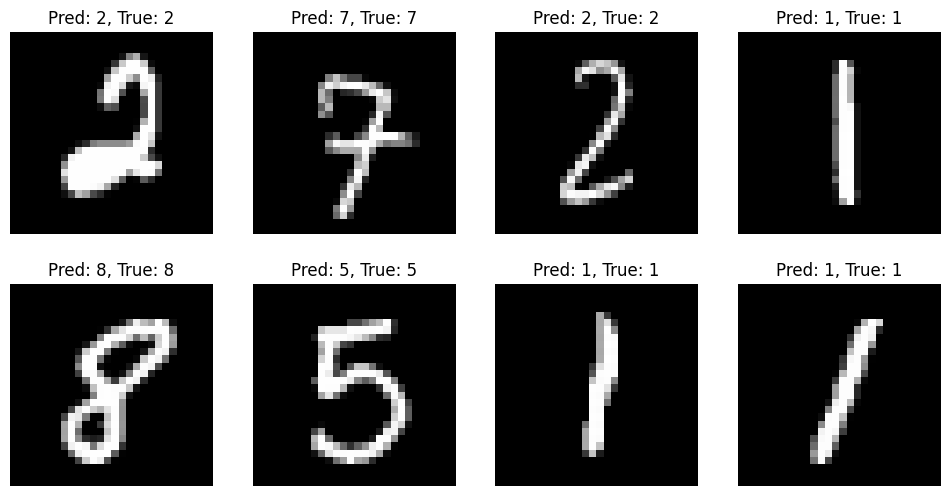

In [39]:

import random

# Pick 8 random indices
indices = random.sample(range(len(full_test)), 8)
images = torch.stack([full_test[i][0] for i in indices])
labels = torch.tensor([full_test[i][1] for i in indices])

images, labels = images.to(device), labels.to(device)

# Model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Plot (for MNIST grayscale)
images = images.cpu().squeeze(1)
preds = preds.cpu()
labels = labels.cpu()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Pred: {preds[i]}, True: {labels[i]}")
    ax.axis('off')
plt.show()



In [ ]:
# import matplotlib.pyplot as plt

# # Get a batch of test data
# images, labels = next(iter(test_loader))
# images, labels = images.to(device), labels.to(device)

# # Forward pass
# model.eval()
# with torch.no_grad():
#     outputs = model(images)
#     preds = torch.argmax(outputs, dim=1)

# # Move to CPU and remove channel dimension for plotting
# images = images.cpu().squeeze(1)
# preds = preds.cpu()
# labels = labels.cpu()

# # Plot first 8 images
# fig, axes = plt.subplots(2, 4, figsize=(12, 6))
# for i, ax in enumerate(axes.flatten()):
#     ax.imshow(images[i], cmap='gray')
#     ax.set_title(f"Pred: {preds[i]}, True: {labels[i]}")
#     ax.axis('off')
# plt.show()
